# Title : Long Short Term Memory Recurrent Neural Network Regression  By Daniel

<img src="img/RNN_tf_truncated_backprop.png">


## Content:  Generating a Sine curve(blue & dash line) which will predict another Cos curve(red line)

<img src="img/SinAndCos.png">

> Are you exciting now?  Follow me, step by step  !!! Just training with CPU. Don't worry about the dame high price of GPU !!!



# TensorBoard 

## Model Graph


<img src="img/Model_Graph.png">

## 0. Set Working Environment

### I recommend you to use "Anocanda(Python Package Management Tool)" setting your Working Environment in this tutorial.

> Anaconda is a distribution of packages built for data science. It comes with conda, a package and environment manager. You'll be using conda to create environments for isolating your projects that use different versions of Python and/or different packages. You'll also use it to install, uninstall, and update packages in your environments. Using Anaconda has made my life working with data much more pleasant.  --- Udacity

> Anaconda is available for Windows, Mac OS X, and Linux. You can find the installers and installation instructions at https://www.continuum.io/downloads.

> Once, you have installed Anacoda in your OS. You can follow me by following steps:

- Step 1. To create an environment. Open your Teminal, then input the following command line.

```
> conda env create -f environment.yaml
```

- Step 2. Entering an environment.

```
> source activate tensorflow
```

## 1. Import Library
### [TensroFlow Offical Website](https://www.tensorflow.org/)
### If you want to know more about numpy and matplotlib, you could visit  [Chris Albon](https://chrisalbon.com/) Blog

In [1]:
# If you want to display plot in Jupyter Notebook, Don't forget add "%matplotlib notebook".
%matplotlib notebook
import tensorflow as tf # Google Deep Learning Framework
import numpy as np # Python Metrix Tool
import matplotlib.pyplot as plt # Python Plot Tool

## 2. Setting Hyperparameter 

- [Deep Learning book - chapter 11.4: Selecting Hyperparameters ](http://www.deeplearningbook.org/contents/guidelines.html)
- [How to choose a neural network's hyper-parameters?](http://neuralnetworksanddeeplearning.com/chap3.html#how_to_choose_a_neural_network's_hyper-parameters)

<img src="img/One_Batch.png">

In [2]:
BATCH_START = 0         # Create Batch Data Index
TIME_STEPS = 20         # the time steps of backpropagation through time 
BATCH_SIZE = 50         # 50 Sample Batches
INPUT_SIZE = 1          # the input size of Sin Curve
OUTPUT_SIZE = 1         # the output size of Cos Curve
CELL_SIZE = 10          # the hidden unit size of RNN
LEARNING_RATE = 0.01    # The single most imortant hyperparameter and one should always make sure that is has been tuned

# 3. LSTM RNN Model 

## 3.0 Weight & Biases Initialization

### Input Data
<img src='img/Inputs.png' >

In [3]:
def weight_variable(shape, name='weights'):
    """
    Weight Variable (Tensor)  
    :param shape: the shape of Tensor
    :param name='weights': the name will be displayed in TensorBoard
    :return: Tensor Weight with shape, initializer, name.
    """
    initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
    return tf.get_variable(shape=shape, initializer=initializer, 
                           name=name)

In [4]:
def bias_variable(shape, name='biases'):
    """
    Biases Variable (Tensor)
    :parame shape: the shape of Tensor
    :parame name='biases': the name will be displayed in TensorBoard
    :return: Tensor Biases with shape, initializer, name.
    """
    initializer = tf.constant_initializer(0.1)
    return tf.get_variable(name=name, shape=shape, initializer=initializer)

## 3.1 Add Input Layer

### Input Layer
<img src='img/input_layer.png'>

In [5]:
def add_input_layer(x_placeholder, input_size, cell_size, n_steps):
    """
    Add one input layer into the neural network
    :param x_placeholder
    :param input_size: the input size of Sin Curve
    :param cell_size: the output size of Cos Curve
    :param n_steps: the number of RNN Cell
    
    :return: the output of input layer
    """
    
    # Due to x_placeholder is 3 Dimension, we should convert it into 2 Demension for "W times X"
    input_layer_x = tf.reshape(x_placeholder,[-1, input_size], name='3D_To_2D') #(batch*n_step, in_size)
    
    # Ws (in_size, cell_size)
    Ws_in = weight_variable([input_size, cell_size])
    
    # bs (cell_size,)
    bs_in = bias_variable([cell_size,])
    # the output of input layer = (batch*n_steps, cell_size)
    with tf.name_scope('Wx_plus_b'):
        input_layer_y = tf.matmul(input_layer_x, Ws_in) + bs_in
        tf.summary.histogram('weights', Ws_in) # TensorBoard Histogram
        tf.summary.histogram('biase', bs_in) # TensorBoard Histogram
    # reshape input_layer_y ==> (batch, n_steps, cell_size)
    input_layer_y = tf.reshape(input_layer_y, [-1, n_steps,cell_size], name='2D_To_3D')
    return input_layer_y

## 3.2 Add LSTM Cell

- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) --- colah's blog

<img src='img/Hidden_Layer.png'>

In [6]:
def add_cell(cell_size, batch_size, input_layer_y):
    """
    Add LSTM RNN Cell
    :param cell_size: the hidden unit size of RNN
    :param batch_size: the size of batch (Form intial state to Final State)
    :param input_layer_y: the input of hidden layer
    
    :return: cell_outputs: the output of hidden layer
    :return: cell_init_state: the input of RNN cell
    :return: cell_final_state: the output of RNN cell
    
    """
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(cell_size, forget_bias=1.0,
                                            state_is_tuple=True)
    with tf.name_scope('initial_state'):
        cell_init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    
    cell_outputs, cell_final_state = tf.nn.dynamic_rnn(lstm_cell,
                                                       input_layer_y,
                                                       initial_state= cell_init_state, 
                                                       time_major=False)
    
    
    return cell_outputs, cell_init_state, cell_final_state

## 3.3 Add Output Layer
<img src='img/Output_Layer.png'>

In [7]:
def add_output_layer(cell_outputs, cell_size, output_size):
    """
    Output Layer
    :param cell_outputs
    :param cell_size
    :param output_size: a scalar
    :return: the prediction of Model
    """
    # shape = (batch * steps, cell_size)
    l_out_x = tf.reshape(cell_outputs, [-1, cell_size], name='3D_To_2D')
    Ws_out = weight_variable([cell_size, output_size])
    bs_out = bias_variable([output_size,])
    # shape = (batch * steps, output_size)
    with tf.name_scope('Wx_plus_b'):
        pred = tf.matmul(l_out_x, Ws_out) + bs_out
        tf.summary.histogram('weights', Ws_out )
        tf.summary.histogram('biase', bs_out)
        return pred

## 3.4 Compute Cost

- [tf.contrib.legacy_seq2seq.sequence_loss_by_example](https://www.tensorflow.org/api_docs/python/tf/contrib/legacy_seq2seq/sequence_loss_by_example) API

> Seq2Seq: A specific architecture of RNNs for generating one sequene form another sequence. In this tutorial, I will use the sequential Sin Curve to predict the seiquential Cos Curve.

### If you are curious about the Seq2Seq, you would be interesting the following link:

- [TensorFlow Seq2Seq Tutorial](https://github.com/ematvey/tensorflow-seq2seq-tutorials)
- [A neural chatbot using sequence to sequence model with attentional decoder](https://github.com/chiphuyen/tf-stanford-tutorials/tree/master/assignments/chatbot)

### You can view  this Video to konw more about Activation Function 
- [Which Activation Function Should I Use?](https://www.youtube.com/watch?v=-7scQpJT7uo) Siraj Raval

<img src='img/cost.png'>

In [8]:
def ms_error(y_target, y_pre):
    """
    Mean Square Error to Calcuate the Loss
    :param  y_target: The output of Cos
    :param  y_pre: The Output of Sin
    :return: mean square error (loss)
    """
    return tf.reduce_mean(tf.squared_difference(y_target, y_pre))

In [9]:
def compute_cost(pred, y_placeholder, batch_size, n_steps):
    """
    Compute Loss
    :param pred: Prediction Value
    :param y_placeholder: the output of Cos Curve
    :param batch_size
    :param n_steps
    :return: cost(loss)
    """
    
    # the loss in every step
    losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
    [tf.reshape(pred,[-1], name='reshape_pred')],
    [tf.reshape(y_placeholder,[-1],name='reshape_target')],
    [tf.ones([batch_size * n_steps], dtype=tf.float32)],
    average_across_timesteps=True,
    softmax_loss_function = ms_error, # Softmax is an Anctivation Function to nonlinear the hidden layer output function
    name='losses'
    )
    with tf.name_scope('average_cost'):
        # Average Cost --- Scalar
        cost = tf.div(tf.reduce_sum(losses, name='losses_sum'),
                      batch_size,
                      name="average_cost")
        tf.summary.scalar('cost', cost) # TensorBoard Event Cost(Loss)
        
        return cost

## Cost (Loss)

> The plot will update the Cost(Loss) Value in every 20 steps. We can get the Cost Value by Mean Square Error Function. When the Cost value convergent 0, we get the optimized function.

<img src='img/loss.png'>

## 3.4 Create LSTM RNN Model

<img src="img/One_Batch.png">

- n_steps : There are 3 RNN Cell in one batch. --- 3 Steps

In [10]:
class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
    
        """
        LSTM RNN Model Architecture
        :param n_steps: how many RNN Cells in one batch
        :param input_size: input size
        :param output_size: output size
        :param cell_size: the hidden unit size of RNN.
        """ 
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size

      
        with tf.name_scope('inputs'):
            # You should use tf.placeholder to feed the tensor into your Model(LSTM RNN)
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size],
                                name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size],
                                name='ys')
        # Input Layer
        with tf.variable_scope('input_layer'):
            self.input_layer_y = add_input_layer(self.xs, input_size, cell_size, n_steps)
        # Hidden Layer
        with tf.variable_scope('Hidden_Layer/LSTM_RNN_Cell'):
            self.cell_outputs, self.cell_init_state, self.cell_final_state = add_cell(cell_size, batch_size, 
                                                                                      self.input_layer_y)
        # Output Layer
        with tf.variable_scope('output_layer'):
            self.pred = add_output_layer(self.cell_outputs, cell_size, output_size)
        # Compute Cost Value to observe error
        with tf.name_scope('cost'):
            self.cost = compute_cost(self.pred, self.ys, batch_size, n_steps)
        # 
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(self.cost)
      
   

## 4.Initial Model & Generate TensorFlow Event Files

In [11]:
# Initial Long Short Term Memory Recurrent Neural Network
model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE,CELL_SIZE, BATCH_SIZE)
# Combine all Summary 
merged = tf.summary.merge_all()

## 4.Train LSTM RNN Model
<img src='img/train.png'>

<IPython.core.display.Javascript object>


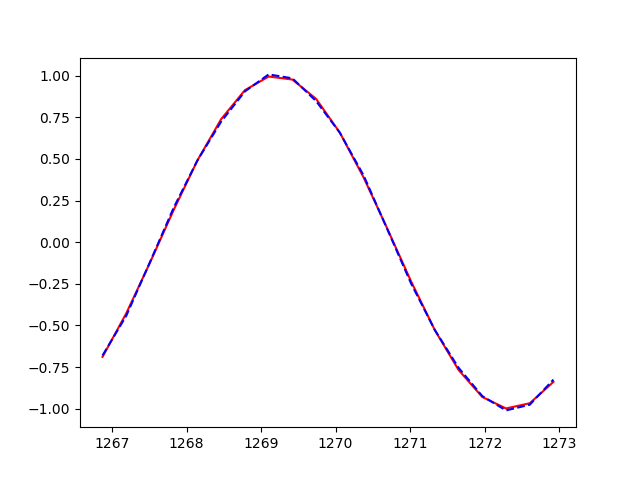

cost:  36.153
cost:  0.5545
cost:  0.1223
cost:  0.0216
cost:  0.0082
cost:  0.0046
cost:  0.0035
cost:  0.0029
cost:  0.0025
cost:  0.0022


In [12]:
with tf.Session() as sess:
    
    # When you run this line, your director will generate a "logs" director,
    # then open your terminal input the following command line
    # > tensorbaord --logdir='logs/'
    writer = tf.summary.FileWriter("logs", sess.graph)  
    sess.run(tf.global_variables_initializer())
    
    #initialise the graph and settings
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()


   
    
    for i in range(200): 
        # Generate xs shape (50 batch, 20 steps)
        x_data = np.arange(BATCH_START, 
                           BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE,TIME_STEPS)) / np.pi

        # Sine Curve (Blue Dash Line)
        seq = np.sin(x_data)[:,:,np.newaxis]
        
        # Cos Curve (Red Line)
        res = np.cos(x_data)[:,:,np.newaxis]

        BATCH_START += TIME_STEPS

        # The current Final State will become the Inital State of the next Batch.
        if i == 0:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
            }
        else: 
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state # the final state as the initial state for this run
            }

        # Trainning 
        _, cost, state, pred = sess.run([model.train_op, model.cost, model.cell_final_state, model.pred],feed_dict = feed_dict)

        # plotting
        ax.clear() # - Clear
        ax.plot(x_data[0, :], res[0].flatten(), 'r', x_data[0, :], pred.flatten()[:TIME_STEPS], 'b--') # fit the line
        fig.canvas.draw()   # draw
       


        # Obeser the cost value in every 20 steps
        if i % 20 == 0:
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result,i)

